In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

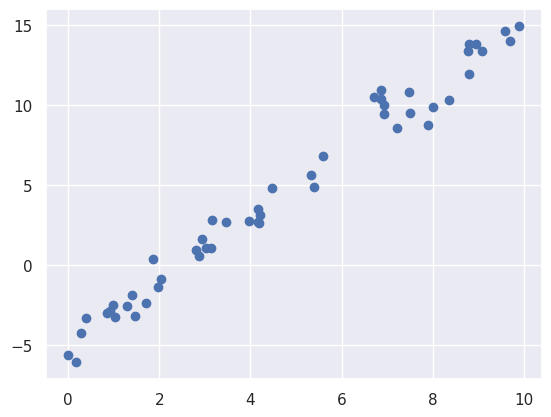

In [4]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

Podemos usar o estimador ``LinearRegression`` do Scikit-Learn para ajustar esses dados e construir a linha de melhor ajuste, mas quem seria a variável alvo e quem seria o 'rotulo'?

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

# model.fit(...., ...) # x[:, np.newaxis], y

Agora para fazer um teste como podemos consultar esta função?

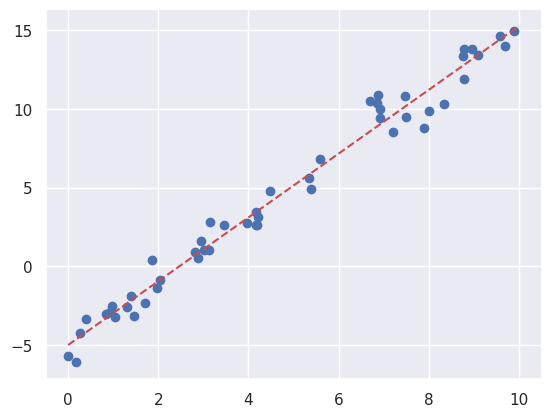

In [11]:
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit,'--r');

A inclinação e o termo livre (a e b) estão contidas nos parâmetros de ajuste do modelo, que no Scikit-Learn são ``coef_`` e ``intercept_``:

In [12]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0272088103606953
Model intercept: -4.998577085553204


Regressão linear multipla

In [13]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000033
[ 1.5 -2.   1. ]


Aqui, os dados $y$ são construídos a partir de três valores $x$ aleatórios, e a regressão linear recupera os coeficientes usados ​​para construir os dados.

Dessa forma, podemos usar o estimador único ``LinearRegression`` para ajustar retas, planos ou hiperplanos aos nossos dados.

Ainda parece que essa abordagem se limitaria a relações estritamente lineares entre variáveis, mas também podemos flexibilizar isso.

## Regressão com transformação de features

O truque que vamos usar para adaptar a regressão linear a relações não lineares entre variáveis ​​é transformar os dados de acordo com *funções base*.

A ideia é pegar nosso modelo linear multidimensional:

$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$

e construir $x_1, x_2, x_3,$ e assim por diante, a partir de nossa entrada unidimensional $x$.

Ou seja, consideramos $x_n = f_n(x)$, onde $f_n()$ é uma função que transforma nossos dados.

Por exemplo, se $f_n(x) = x^n$, nosso modelo se torna uma regressão polinomial:

$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$

Observe que este *ainda é um modelo linear* — a linearidade se refere ao fato de que os coeficientes $a_n$ nunca se multiplicam ou se dividem.

O que efetivamente fizemos foi pegar nossos valores unidimensionais de $x$ e projetá-los em uma dimensão superior, de modo que um ajuste linear possa ajustar relações mais complexas entre $x$ e $y$.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [19]:
from sklearn.preprocessing import PolynomialFeatures

x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

As we saw in [Feature Engineering](05.04-Feature-Engineering.ipynb), the cleanest way to accomplish this is to use a pipeline.
Let's make a 7th-degree polynomial model in this way:

In [21]:
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$.
For example, here is a sine wave with noise:

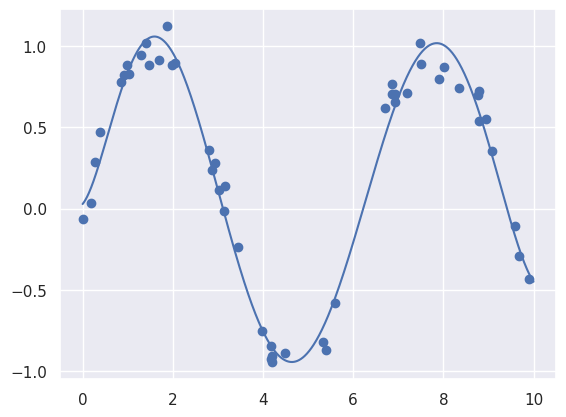

In [22]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

## Example: Predicting Bicycle Traffic

Como exemplo, vamos verificar se podemos prever o número de viagens de bicicleta pela Ponte Fremont, em Seattle, com base no clima, na estação do ano e em outros fatores.

Vamos juntar os dados das bicicletas a outro conjunto de dados e tentaremos determinar em que medida os fatores climáticos e sazonais — temperatura, precipitação e horas de luz do dia — afetam o volume de tráfego de bicicletas por este corredor.

Felizmente, a NOAA disponibiliza seus [dados diários das estações meteorológicas](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) e podemos facilmente usar o Pandas para unir as duas fontes de dados.

Realizaremos uma regressão linear simples para relacionar informações meteorológicas e outras informações à contagem de bicicletas, a fim de estimar como uma mudança em qualquer um desses parâmetros afeta o número de ciclistas em um determinado dia.

In [23]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3495k    0 3495k    0     0  1404k      0 --:--:--  0:00:02 --:--:-- 1403k


In [24]:
import pandas as pd

counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

/tmp/ipython-input-1592612346.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)


FileNotFoundError: [Errno 2] No such file or directory: 'data/BicycleWeather.csv'

Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [ ]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

We saw previously that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [ ]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

In [ ]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also add the average temperature and total precipitation to the data.
In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [ ]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Finally, let's add a counter that increases from day 1, and measures how many years have passed.
This will let us measure any observed annual increase or decrease in daily crossings:

In [ ]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [ ]:
daily.head()

With this in place, we can choose the columns to use, and fit a linear regression model to our data.
We will set ``fit_intercept = False``, because the daily flags essentially operate as their own day-specific intercepts:

In [ ]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

In [ ]:
daily[['Total', 'predicted']].plot(alpha=0.5);

It is evident that we have missed some key features, especially during the summer time.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).
Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [ ]:
params = pd.Series(model.coef_, index=X.columns)
params

These numbers are difficult to interpret without some measure of their uncertainty.
We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [ ]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

With these errors estimated, let's again look at the results:

In [ ]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays.
We see that for each additional hour of daylight, 129 ± 9 more people choose to ride; a temperature increase of one degree Celsius encourages 65 ± 4 people to grab their bicycle; a dry day means an average of 548 ± 33 more riders, and each inch of precipitation means 665 ± 62 more people leave their bike at home.
Once all these effects are accounted for, we see a modest increase of 27 ± 18 new daily riders each year.

Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model.
Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days).
These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

<!--NAVIGATION-->
< [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb) | [Contents](Index.ipynb) | [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
